# [Dacon] 주식 종료 가격 예측 경진 대회

In [ ]:
!nvidia-smi

Sun Nov 28 14:18:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 필요 라이브러리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install finance-datareader

In [ ]:
pip install yfinance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import datetime as dt
from datetime import datetime

import FinanceDataReader as fdr
import yfinance as yf

from sklearn.preprocessing import RobustScaler

In [ ]:
#path = "/content/drive/Othercomputers/내 노트북/PredictStockClosePrice/"
path = "/content/drive/MyDrive/PredictStockClosePrice/"
stock_list = pd.read_csv(path + "data/stock_list.csv")

In [ ]:
start_year = '2020'
start_date = start_year + '-12-01'
end_date = '2021-10-31'

days_train = 25
days_target = 25

# 데이터셋 불러오기

## KRX

In [ ]:
# KODEX 200과 TIGER 200은 코스피 200을 추종하는 패시브 etf이므로 이를 이용하여 Pre-Training
stock_list.loc[(stock_list['종목명'] == 'KODEX 200') | (stock_list['종목명'] == 'TIGER 200')]

,종목명,종목코드,상장시장
68,KODEX 200,69500,KOSPI
134,TIGER 200,102110,KOSPI


In [ ]:
# 데이터에 etf가 있다
kospi_codes = []
kospi_coms = {}
kosdaq_codes = []
kosdaq_coms = {}

for i in range(len(stock_list)):
    code = stock_list['종목코드'][i]
    if (stock_list['상장시장'][i] == 'KOSPI'):
        kospi_codes.append(str(code).zfill(6))
        kospi_coms[str(code).zfill(6)] = stock_list['종목명'][i]
    else:
        kosdaq_codes.append(str(code).zfill(6))
        kosdaq_coms[str(code).zfill(6)] = stock_list['종목명'][i]

CODES = kospi_codes + kosdaq_codes
# codes = {'kospi' : kospi_codes, 'kosdaq' : kosdaq_codes}

In [ ]:
def getPrice(code, start_date = start_date,  end_date = end_date, CODES=CODES):
    # 한국거래소 주식 시장은 1월 1일과 12월 31일, 공휴일, 주말이 휴장이다.
    df = fdr.DataReader(code, start = start_date, end = end_date) # 날짜: 월 일 연도
    df = df.drop(['Change'], axis=1)
    
    col = list(df.columns).index('Close')
    col_order = list(df.columns[:col]) + list(df.columns[col+1:]) + list(df.columns[col:col+1])
    df = df[col_order]
    df.loc[:,'Close_diff'] = df['Close'].diff().fillna(0)
    if 'Volume' in df.columns:
      df.loc[:,'Close_vol_diff'] = (df['Close'] * df['Volume']).diff().fillna(0)
      df.loc[:,'Close_vol_diff_integral'] = df['Close_vol_diff'].cumsum()
    
    col = list(df.columns).index('Close')
    col_order = list(df.columns[col:]) + list(df.columns[:col])
    df = df[col_order]
    
    if code in kospi_codes:
      df.loc[:, 'KOSPI'] = 1
      df.loc[:, 'KOSDAQ'] = 0
    elif code in kosdaq_codes:
      df.loc[:, 'KOSPI'] = 0
      df.loc[:, 'KOSDAQ'] = 1
    else:
      print("ERROR "*100)
      return
    
    for CODE in CODES:
        df.loc[:, CODE] = 1 if CODE == code else 0
        

    # stock.loc[:, 'O-C'] = stock['Open'] - stock['Close']
    # stock.loc[:, 'H-L'] = stock['High'] - stock['Low']
    # stock.loc[:, 'O-L'] = stock['Open'] - stock['Low']
    # stock.loc[:, 'O-H'] = stock['Open'] - stock['High']
    # stock.loc[:, 'C-L'] = stock['Close'] - stock['Low']
    # stock.loc[:, 'C-H'] = stock['Close'] - stock['High']

    return df

In [ ]:
len(CODES)

370

## Extra Info

In [ ]:
def getInfo(symbol, start_date = start_date,  end_date = end_date):
  if symbol == 'KS11' or 'KQ11':
      df = fdr.DataReader('KS11', start_date, end_date)
  else:
      df = yf.Ticker(symbol).history(start=start_date, end=end_date)
      #df = df.drop(['Dividends', "Stock Splits"], axis=1) 

  #if df['Volume'].any() == 0:
  #df = df.drop(['Volume'], adfis=1)

  col = list(df.columns).index('Close')
  col_order = list(df.columns[:col]) + list(df.columns[col+1:]) + list(df.columns[col:col+1])
  df = df[col_order]
  
  df.loc[:, 'Close_lag1'] = df['Close'].shift(1)
  df.loc[:, 'Close_back1'] = df['Close'].shift(-1)
  df.loc[:, 'Close_lag2'] = df['Close'].shift(2)
  df.loc[:, 'Close_back2'] = df['Close'].shift(-2)
  df.loc[:, 'Close_lag3'] = df['Close'].shift(3)
  df.loc[:, 'Close_back3'] = df['Close'].shift(-3)

  df.loc[:, 'Close_diff1'] = df['Close'] - df['Close_lag1']
  df.loc[:, 'Close_diff2'] = df['Close'] - df['Close_lag2']
  df.loc[:, 'Close_diff3'] = df['Close'] - df['Close_lag3']

  df.loc[:, 'SMA_Close_mean_5'] = df['Close'].rolling(5).mean()
  
  df.loc[:, 'SMA_Close_mean_10'] = df['Close'].rolling(10).mean()

  
  df.loc[:, 'EMA_Close_mean_5'] = df['Close'].ewm(5).mean()
  
  df.loc[:, 'EMA_Close_mean_10'] = df['Close'].ewm(10).mean()

  df.loc[:, 'Close_diff1_back'] = df['Close'] - df['Close_back1']
  df.loc[:, 'Close_diff2_back'] = df['Close'] - df['Close_back2']    

  df = df.fillna(0)

  col = list(df.columns).index('Close')
  col_order = list(df.columns[col:])
  df = df[col_order]
  
  return df

In [ ]:
def getExtraInfo(start_date=start_date, end_date=end_date):
    KOSPI = getInfo('KS11', start_date, end_date) #코스피 지수
    print("="*5, ">>> KOSPI <<<", "="*5)
    KOSDAQ = getInfo('KQ11', start_date, end_date) #코스닥 지수
    print("="*5, ">>> KOSDAQ <<<", "="*5)

    USD_KRW = fdr.DataReader('USD/KRW', start_date, end_date)
    print("="*5, ">>> USD <<<", "="*5)
    CNY_KRW = fdr.DataReader('CNY/KRW', start_date, end_date)
    print("="*5, ">>> CNY <<<", "="*5)

    # 원자재
    Gold = getInfo("GC=F", start_date, end_date) # 국제 금
    print("="*5, ">>> Gold <<<", "="*5)
    CrudeOil = getInfo("CL=F", start_date, end_date) # 원유
    print("="*5, ">>> Crude Oil <<<", "="*5)

    # 미국채
    Treasury5yr = getInfo("^FVX", start_date, end_date) # 5 years
    print("="*5, ">>> Treasury 5 years <<<", "="*5)
    Treasury10yr = getInfo("^TNX", start_date, end_date) # 10 years
    print("="*5, ">>> Treasury 10 years <<<", "="*5)

    # 미국 증시
    # 지수
    SP500 = getInfo("^GSPC", start_date, end_date) # S&P500
    print("="*5, ">>> S&P500 <<<", "="*5)
    DJI = getInfo("^DJI", start_date, end_date) # Dow30
    print("="*5, ">>> DJI <<<", "="*5)
    NASDAQ = getInfo("^IXIC", start_date, end_date) # Nasdaq
    print("="*5, ">>> NASDAQ <<<", "="*5)

    # 가상 자산
    BTC = getInfo('BTC-USD', start_date, end_date) # Bitcoin USD
    print("="*5, ">>> BTC <<<", "="*5)
    ETH = getInfo('ETH-USD', start_date, end_date) # Ethereum USD
    print("="*5, ">>> ETH <<<", "="*5)

    Info = pd.concat([KOSPI, KOSDAQ, USD_KRW, CNY_KRW, Gold, CrudeOil, Treasury5yr, Treasury10yr, SP500, DJI, NASDAQ, BTC, ETH], axis=1)
    # EUR_KRW, JPY_KRW, GBP_KRW, 
    # MSFT, AAPL, AMZN, TSLA, GOOGL, META, NVDA, TSM, JPM, V, BAC, XOM, 
    Info = (Info.fillna(method='pad') + Info.fillna(method='bfill')) / 2 # 사이에 결측치 있을 때
    Info = Info.fillna(method='bfill') # 앞에 결측치 있을 때
    Info = Info.fillna(method='pad') # 뒤에 결측치 있을 때

    return Info

# Feature Engineering

In [ ]:
def add_features(df):

    # Step 1    
    df.loc[:, 'H-L'] = df['High'] - df['Low']
    df.loc[:, 'O-C'] = df['Open'] - df['Close']
    df.loc[:, 'O-H'] = df['Open'] - df['High']
    df.loc[:, 'O-L'] = df['Open'] - df['Low']
    df.loc[:, 'C-H'] = df['Close'] - df['High']
    df.loc[:, 'C-L'] = df['Close'] - df['Low']
    
    if 'Volume' in df.columns:
      df.loc[:, 'Vol_diff'] = df['Volume'].diff().fillna(0)
    
    # Step 2
    df.loc[:, 'O-C_lag1'] = df['O-C'].shift(1)
    df.loc[:, 'O-C_back1'] = df['O-C'].shift(-1)
    df.loc[:, 'O-C_lag2'] = df['O-C'].shift(2)
    df.loc[:, 'O-C_back2'] = df['O-C'].shift(-2)
    df.loc[:, 'O-C_lag3'] = df['O-C'].shift(3)
    df.loc[:, 'O-C_back3'] = df['O-C'].shift(-3)

    df.loc[:, 'C-H_lag1'] = df['C-H'].shift(1)
    df.loc[:, 'C-H_back1'] = df['C-H'].shift(-1)
    df.loc[:, 'C-H_lag2'] = df['C-H'].shift(2)
    df.loc[:, 'C-H_back2'] = df['C-H'].shift(-2)
    df.loc[:, 'C-H_lag3'] = df['C-H'].shift(3)
    df.loc[:, 'C-H_back3'] = df['C-H'].shift(-3)

    df.loc[:, 'C-L_lag1'] = df['C-L'].shift(1)
    df.loc[:, 'C-L_back1'] = df['C-L'].shift(-1)
    df.loc[:, 'C-L_lag2'] = df['C-L'].shift(2)
    df.loc[:, 'C-L_back2'] = df['C-L'].shift(-2)
    df.loc[:, 'C-L_lag3'] = df['C-L'].shift(3)
    df.loc[:, 'C-L_back3'] = df['C-L'].shift(-3)

    df.loc[:, 'Close_lag1'] = df['Close'].shift(1)
    df.loc[:, 'Close_back1'] = df['Close'].shift(-1)
    df.loc[:, 'Close_lag2'] = df['Close'].shift(2)
    df.loc[:, 'Close_back2'] = df['Close'].shift(-2)
    df.loc[:, 'Close_lag3'] = df['Close'].shift(3)
    df.loc[:, 'Close_back3'] = df['Close'].shift(-3)
    
    """
    df.loc[:, 'Close_diff_lag1'] = df['Close_diff'].shift(1)
    df.loc[:, 'Close_diff_back1'] = df['Close_diff'].shift(-1)
    df.loc[:, 'Close_diff_lag2'] = df['Close_diff'].shift(2)
    df.loc[:, 'Close_diff_back2'] = df['Close_diff'].shift(-2)
    df.loc[:, 'Close_diff_lag3'] = df['Close_diff'].shift(3)
    df.loc[:, 'Close_diff_back3'] = df['Close_diff'].shift(-3)
    """

    if 'Volume' in df.columns:
      df.loc[:, 'Close_vol_diff_lag1'] = df['Close_vol_diff'].shift(1)
      df.loc[:, 'Close_vol_diff_back1'] = df['Close_vol_diff'].shift(-1)
      df.loc[:, 'Close_vol_diff_lag2'] = df['Close_vol_diff'].shift(2)
      df.loc[:, 'Close_vol_diff_back2'] = df['Close_vol_diff'].shift(-2)
      df.loc[:, 'Close_vol_diff_lag3'] = df['Close_vol_diff'].shift(3)
      df.loc[:, 'Close_vol_diff_back3'] = df['Close_vol_diff'].shift(-3)

      df.loc[:, 'Vol_diff_lag1'] = df['Vol_diff'].shift(1)
      df.loc[:, 'Vol_diff_back1'] = df['Vol_diff'].shift(-1)
      df.loc[:, 'Vol_diff_lag2'] = df['Vol_diff'].shift(2)
      df.loc[:, 'Vol_diff_back2'] = df['Vol_diff'].shift(-2)
      df.loc[:, 'Vol_diff_lag3'] = df['Vol_diff'].shift(3)
      df.loc[:, 'Vol_diff_back3'] = df['Vol_diff'].shift(-3)
    
    # Step 3
    if 'Volume' in df.columns:
      df.loc[:, 'Volume_max_Close'] = (df.loc[df['Volume'] == df['Volume'].max()])['Close']
      df.loc[:, 'Volume_mean_Close'] = (df.loc[df['Volume'] - df['Volume'].mean() < 1])['Close'].mean()
      df.loc[:, 'Volume_max_Close_diff'] = (df.loc[df['Volume'] == df['Volume'].max()])['Close'] - df['Close']
      df.loc[:, 'Volume_max_Close_diff'] = (df.loc[df['Volume'] == df['Volume'].max()])['Close'] - df['Close']
    else:
      print("Step 3 ... df has no Volume")
      df.loc[:, 'Close_max'] = df['Close'].max()
      df.loc[:, 'Close_mean'] = df['Close'].mean()
      df.loc[:, 'Close_max_diff'] = df['Close_max'] - df['Close']
      df.loc[:, 'Close_max_diff'] = df['Close_mean'] - df['Close']
    
    # Step 4
    df.loc[:, 'O-C_diff1'] = df['O-C'] - df['O-C_lag1']
    df.loc[:, 'O-C_diff2'] = df['O-C'] - df['O-C_lag2']
    df.loc[:, 'O-C_diff3'] = df['O-C'] - df['O-C_lag3']

    df.loc[:, 'C-H_diff1'] = df['C-H'] - df['C-H_lag1']
    df.loc[:, 'C-H_diff2'] = df['C-H'] - df['C-H_lag2']
    df.loc[:, 'C-H_diff3'] = df['C-H'] - df['C-H_lag3']

    df.loc[:, 'C-L_diff1'] = df['C-L'] - df['C-L_lag1']
    df.loc[:, 'C-L_diff2'] = df['C-L'] - df['C-L_lag2']
    df.loc[:, 'C-L_diff3'] = df['C-L'] - df['C-L_lag3']

    df.loc[:, 'Close_diff1'] = df['Close'] - df['Close_lag1']
    df.loc[:, 'Close_diff2'] = df['Close'] - df['Close_lag2']
    df.loc[:, 'Close_diff3'] = df['Close'] - df['Close_lag3']
    
    if 'Volume' in df.columns:
      df.loc[:, 'Close_vol_diff_diff1'] = df['Close_vol_diff'] - df['Close_vol_diff_lag1']
      df.loc[:, 'Close_vol_diff_diff2'] = df['Close_vol_diff'] - df['Close_vol_diff_lag2']
      df.loc[:, 'Close_vol_diff_diff3'] = df['Close_vol_diff'] - df['Close_vol_diff_lag3']

      df.loc[:, 'Vol_diff_diff1'] = df['Vol_diff'] - df['Vol_diff_lag1']
      df.loc[:, 'Vol_diff_diff2'] = df['Vol_diff'] - df['Vol_diff_lag2']
      df.loc[:, 'Vol_diff_diff3'] = df['Vol_diff'] - df['Vol_diff_lag3']
    
    # Step 6
    # 단순 이동 평균
    df.loc[:, 'SMA_Close_mean_5'] = df['Close'].rolling(5).mean()
    
    df.loc[:, 'SMA_Close_mean_10'] = df['Close'].rolling(10).mean()

    # 지수 이동 평균
    df.loc[:, 'EMA_Close_mean_5'] = df['Close'].ewm(5).mean()
    
    df.loc[:, 'EMA_Close_mean_10'] = df['Close'].ewm(10).mean()

    # Step 7
    #df.loc[:, 'SMA_diff_5_10'] = df['SMA_Close_mean_5'] - df['SMA_Close_mean_10']

    #df.loc[:, 'EMA_diff_5_10'] = df['EMA_Close_mean_5'] - df['EMA_Close_mean_10']
    
    # Step 8
    df.loc[:, 'O-C_diff1_back'] = df['O-C'] - df['O-C_back1']
    df.loc[:, 'O-C_diff2_back'] = df['O-C'] - df['O-C_back2']

    df.loc[:, 'C-H_diff1_back'] = df['C-H'] - df['C-H_back1']
    df.loc[:, 'C-H_diff2_back'] = df['C-H'] - df['C-H_back2']

    df.loc[:, 'C-L_diff1_back'] = df['C-L'] - df['C-L_back1']
    df.loc[:, 'C-L_diff2_back'] = df['C-L'] - df['C-L_back2']

    df.loc[:, 'Close_diff1_back'] = df['Close'] - df['Close_back1']
    df.loc[:, 'Close_diff2_back'] = df['Close'] - df['Close_back2']

    if 'Volume' in df.columns:
      df.loc[:, 'Close_vol_diff_diff1_back'] = df['Close_vol_diff'] - df['Close_vol_diff_back1']
      df.loc[:, 'Close_vol_diff_diff2_back'] = df['Close_vol_diff'] - df['Close_vol_diff_back2']

      df.loc[:, 'Vol_diff_diff1_back'] = df['Vol_diff'] - df['Vol_diff_back1']
      df.loc[:, 'Vol_diff_diff2_back'] = df['Vol_diff'] - df['Vol_diff_back2']


    # 결측치 처리
    df = df.fillna(0)
    #df = (df.fillna(method='pad') + df.fillna(method='bfill')) / 2 # 사이에 결측치 있을 때
    #df = df.fillna(method='bfill') # 앞에 결측치 있을 때
    #df = df.fillna(method='pad') # 뒤에 결측치 있을 때
    
    print(">>> Completed Adding Features")
    return df

# Build Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers  import MultiHeadAttention, LayerNormalization, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split, KFold

## Model 1

In [ ]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, num_heads, embed_dim, ff_dim, feat_dim, dropout_rate=0.1):

        super(TransformerBlock, self).__init__()

        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
                                     Dense(ff_dim, activation="gelu"), 
                                     Dense(feat_dim)])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)

        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)

        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [ ]:
feat_dim = 1024 #460 + 186 # stock(460) + Info(186) = 646
embed_dim = 64  # Embedding size for attention
num_heads_train = days_train # Number of attention heads
num_heads_target = days_target # Number of attention heads
ff_dim = 2048 # Hidden layer size in feed forward network inside transformer
dropout_rate = 0.0
num_blocks = 3

def build_model():
    inputs = Input(shape=(days_train, 646))
        
    # "EMBEDDING LAYER"
    x = Dense(feat_dim)(inputs)
    x = LayerNormalization(epsilon=1e-6)(x)
    
    # TRANSFORMER BLOCKS
    for k in range(num_blocks):
        x_old = x
        if k == num_blocks-1:
            transformer_block = TransformerBlock(num_heads_target, embed_dim, ff_dim, feat_dim, dropout_rate)
            x = transformer_block(x)
        else:
            transformer_block = TransformerBlock(num_heads_train, embed_dim, ff_dim, feat_dim, dropout_rate)
            x = transformer_block(x)
        x = 0.7*x + 0.3*x_old # SKIP CONNECTION
    
    # REGRESSION HEAD
    x = Dense(1024, activation="selu")(x) # 128
    x = Dropout(dropout_rate)(x)
    x = Dense(256, activation="selu")(x) #
    x = Dropout(dropout_rate)(x) #
    outputs = Dense(4, activation="linear")(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
        
    return model

In [ ]:
model = build_model()
# model.build()
model.summary()
del model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 646)]    0           []                               
                                                                                                  
 dense (Dense)                  (None, 25, 1024)     662528      ['input_1[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 25, 1024)    2048        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 transformer_block (Transformer  (None, 25, 1024)    10760896    ['layer_normalization[0][0]']

## Model 2

In [ ]:
def build_model_stacking():
    return tf.keras.Sequential([
                                Dense(1024, activation='selu'),
                                Dropout(0.1),
                                #Dense(512, activation='selu'),
                                #Dropout(0.1),
                                Dense(256, activation='selu'),
                                Dropout(0.1),
                                Dense(64, activation='selu'),
                                Dropout(0.1),
                                #Dense(16, activation='selu'),
                                #Dropout(0.1),
                                Dense(1, activation='linear')
                                ])

In [ ]:
"""
feat_dim_stacking = 64 # 4*12
embed_dim_stacking = 64  # Embedding size for attention
num_heads_train_stacking = days_train # Number of attention heads
num_heads_target_stacking = days_target # Number of attention heads
ff_dim_stacking = 128 # Hidden layer size in feed forward network inside transformer
dropout_rate_stacking = 0.0
num_blocks_stacking = 5

def build_model_stacking():
    inputs = Input(shape=(days_train, 48))
        
    # "EMBEDDING LAYER"
    x = Dense(feat_dim_stacking)(inputs)
    x = LayerNormalization(epsilon=1e-6)(x)
    
    # TRANSFORMER BLOCKS
    for k in range(num_blocks_stacking):
        x_old = x
        if k == num_blocks_stacking-1:
            transformer_block = TransformerBlock(num_heads_target_stacking, embed_dim_stacking, ff_dim_stacking, feat_dim_stacking, dropout_rate_stacking)
            x = transformer_block(x)
        else:
            transformer_block = TransformerBlock(num_heads_train_stacking, embed_dim_stacking, ff_dim_stacking, feat_dim_stacking, dropout_rate_stacking)
            x = transformer_block(x)
        x = 0.7*x + 0.3*x_old # SKIP CONNECTION
    
    # REGRESSION HEAD
    x = Dense(128, activation="selu")(x) # 128
    x = Dropout(dropout_rate)(x)
    outputs = Dense(4, activation="linear")(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
        
    return model
"""    

'\nfeat_dim_stacking = 64 # 4*12\nembed_dim_stacking = 64  # Embedding size for attention\nnum_heads_train_stacking = days_train # Number of attention heads\nnum_heads_target_stacking = days_target # Number of attention heads\nff_dim_stacking = 128 # Hidden layer size in feed forward network inside transformer\ndropout_rate_stacking = 0.0\nnum_blocks_stacking = 5\n\ndef build_model_stacking():\n    inputs = Input(shape=(days_train, 48))\n        \n    # "EMBEDDING LAYER"\n    x = Dense(feat_dim_stacking)(inputs)\n    x = LayerNormalization(epsilon=1e-6)(x)\n    \n    # TRANSFORMER BLOCKS\n    for k in range(num_blocks_stacking):\n        x_old = x\n        if k == num_blocks_stacking-1:\n            transformer_block = TransformerBlock(num_heads_target_stacking, embed_dim_stacking, ff_dim_stacking, feat_dim_stacking, dropout_rate_stacking)\n            x = transformer_block(x)\n        else:\n            transformer_block = TransformerBlock(num_heads_train_stacking, embed_dim_stacking,

In [ ]:
model = build_model_stacking()
model.build((25, 48))
model.summary()
del model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (25, 1024)                50176     
                                                                 
 dropout_8 (Dropout)         (25, 1024)                0         
                                                                 
 dense_11 (Dense)            (25, 256)                 262400    
                                                                 
 dropout_9 (Dropout)         (25, 256)                 0         
                                                                 
 dense_12 (Dense)            (25, 64)                  16448     
                                                                 
 dropout_10 (Dropout)        (25, 64)                  0         
                                                                 
 dense_13 (Dense)            (25, 1)                  

# Training

## Function: Dataset

In [ ]:
Info = getExtraInfo(start_date, end_date)

===== >>> KOSPI <<< =====
===== >>> KOSDAQ <<< =====
===== >>> USD <<< =====
===== >>> CNY <<< =====
===== >>> Gold <<< =====
===== >>> Crude Oil <<< =====
===== >>> Treasury 5 years <<< =====
===== >>> Treasury 10 years <<< =====
===== >>> S&P500 <<< =====
===== >>> DJI <<< =====
===== >>> NASDAQ <<< =====
===== >>> BTC <<< =====
===== >>> ETH <<< =====


In [ ]:
def getData(code, start_date=start_date, end_date=end_date, days_train=days_train, days_target=days_target, Info=Info, prediction=False):

    stock = getPrice(code, start_date, end_date)
    if stock.empty:
        if code in kospi_codes:
            print("KOSPI : NO IR")
            stock = fdr.DataReader('KS11', start_date, end_date)
        elif code in kosdaq_codes:
            print("KOSDAQ : NO IR")
            stock = fdr.DataReader('KQ11', start_date, end_date)
        else:
          print("ERROR "*100)
          return
        
    stock = add_features(stock)
    dataset = pd.concat([stock, Info], axis=1).dropna()
    #print(dataset.shape)

    # Robust Scaler
    RS = RobustScaler()
    dataset = RS.fit_transform(dataset.astype('float32'))

    if prediction == True:
        dataset = dataset[-25:, ]
        #dataset = dataset['2021-09-23']

    days_total = days_train + days_target
    n = 1
    sample_num = (dataset.shape[0] - (days_total - 1))
    if prediction == True:
        days_total = 25
        sample_num = 1

    X_Data = np.zeros((1, days_train, dataset.shape[-1]))
    y_Data = np.zeros((1, days_train, 4))

    # X = np.zeros((sample_num // n, days_train, feat_dim))
    # 모델의 결과와 정답의 사이즈가 맞지 않아 조정했다. 원하는 날은 25일이므로 이후 값은 0으로 처리.
    # y = np.zeros((sample_num // n, days_train, 5)) # Close, Open, High, Low, Volume

    # 하루 단위로 샘플링    
    for i in range(0, sample_num, n):
      X = dataset[np.newaxis, i: i+days_train, :]
      X_Data = np.concatenate((X_Data, X), axis=0)
      if prediction == False:
          y = dataset[np.newaxis, i+days_train: i+days_total, :4]
          y_Data = np.concatenate((y_Data, y), axis=0)
          del y

      del X

    # train_set test_set split
    #X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=21)

    return X_Data[1:, :, :], y_Data[1:, :, :] #X_train, X_valid, y_train, y_valid

In [ ]:
def getDataset(CODES=CODES, start_date=start_date, end_date=end_date, days_train=days_train, days_target=days_target, Info=Info):
    # X_train_Dataset = []
    # y_train_Dataset = []
    # X_valid_Dataset = []
    # y_valid_Dataset = []
    X_Dataset = np.zeros((1, days_train, 646))
    y_Dataset = np.zeros((1, days_train, 4))
    i = 1
    for CODE in CODES:
        print(f"--->>>get Data of {CODE} ... {i} of {len(CODES)}<<<---")
        #X_train, X_valid, y_train, y_valid = getData(CODE, start_date=start_date, end_date=end_date, days_train=days_train, days_target=days_target, Info=Info)
        X, y = getData(CODE, start_date=start_date, end_date=end_date, days_train=days_train, days_target=days_target, Info=Info)
        print(X.shape)
        # X_train_Dataset = np.concatenate((X_train_Dataset, X_train), axis=0)
        # y_train_Dataset = np.concatenate((y_train_Dataset, y_train), axis=0)
        # X_valid_Dataset = np.concatenate((X_valid_Dataset, X_valid), axis=0)
        # y_valid_Dataset = np.concatenate((y_valid_Dataset, y_valid), axis=0)

        X_Dataset = np.concatenate((X_Dataset, X), axis=0)
        y_Dataset = np.concatenate((y_Dataset, y), axis=0)

        del X
        del y
        i += 1
    
    # X_Dataset = np.concatenate((X[CODE] for CODE in CODES), axis=0)
    # y_Dataset = np.concatenate((y[CODE] for CODE in CODES), axis=0)

    

    return X_Dataset[1:, :, :], y_Dataset[1:, :, :] # X_train_Dataset, y_train_Dataset, X_valid_Dataset, y_valid_Dataset

In [ ]:
def InverseScale(y_pred, code, start_date=start_date, end_date=end_date, Info=Info):
    stock = getPrice(code, start_date, end_date)
    stock = add_features(stock)
    dataset = pd.concat([stock, Info], axis=1).dropna()
    
    #dataset = dataset['2021-09-23':]

    # Robust Scaler
    RS = RobustScaler()
    RS.fit(dataset.astype('float32'))

    return RS.inverse_transform(y_pred)

## Function: Model Training

Learning rate schedule: 0.0006 to 0.0006 to 1e-06


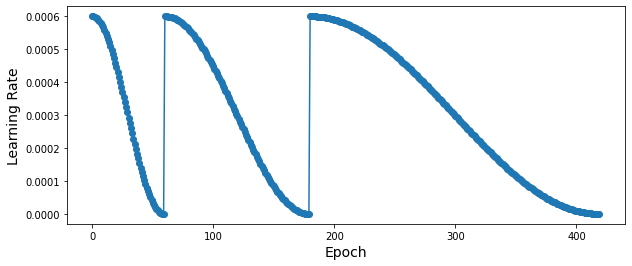

In [ ]:
import math

LR_START = 1e-6
LR_MAX = 6e-4
LR_MIN = 1e-6
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS = 420
STEPS = [60,120,240]


def lrfn(epoch):
    if epoch<STEPS[0]:
        epoch2 = epoch
        EPOCHS2 = STEPS[0]
    elif epoch<STEPS[0]+STEPS[1]:
        epoch2 = epoch-STEPS[0]
        EPOCHS2 = STEPS[1]
    elif epoch<STEPS[0]+STEPS[1]+STEPS[2]:
        epoch2 = epoch-STEPS[0]-STEPS[1]
        EPOCHS2 = STEPS[2]
    
    if epoch2 < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch2 + LR_START
    elif epoch2 < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
          format(lr_y[0], max(lr_y), lr_y[-1]))
plt.xlabel('Epoch',size=14)
plt.ylabel('Learning Rate',size=14)
plt.show()
del lr_callback

## Function: Stack

In [ ]:
def stack(code, start_date=start_date, end_date=end_date, days_train=days_train, days_target=days_target, Info=Info, prediction=False):
    X, y = getData(code, start_date=start_date, end_date=end_date, days_train=days_train, days_target=days_target, Info=Info, prediction=prediction)
    
    X_stack = np.zeros((X.shape[0], days_train, 1))
    for i in range(1, 12+1):
        model = build_model()
        optimizer = keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss="mae")

        checkpoint_folderpath = path + f"weights/{i}/"
        checkpoint_filepath = path + f"weights/{i}/weights"
        if os.path.isdir(checkpoint_folderpath):
            print(f"Loading Fold #{i} Weights")
            model.load_weights(checkpoint_filepath)
        else:
            print(f">>ERROR Fold #{i}<<"*12)
            break;
        
        if prediction == False:
            y_pred = model.predict(X, batch_size=176, verbose=1)
        else:
            y_pred = model.predict(X, verbose=1)
        
        X_stack = np.concatenate((X_stack, y_pred), axis=-1)

        del model
        del optimizer
    
    return X_stack[:, :, 1:], y

## Train

### Train

In [ ]:
X_Dataset, y_Dataset = getDataset(CODES)
del Info

--->>>get Data of 005930 ... 1 of 370<<<---
>>> Completed Adding Features
(176, 25, 646)
--->>>get Data of 000660 ... 2 of 370<<<---
>>> Completed Adding Features
(176, 25, 646)
--->>>get Data of 035420 ... 3 of 370<<<---
>>> Completed Adding Features
(176, 25, 646)
--->>>get Data of 035720 ... 4 of 370<<<---
>>> Completed Adding Features
(176, 25, 646)
--->>>get Data of 207940 ... 5 of 370<<<---
>>> Completed Adding Features
(176, 25, 646)
--->>>get Data of 005935 ... 6 of 370<<<---
>>> Completed Adding Features
(176, 25, 646)
--->>>get Data of 051910 ... 7 of 370<<<---


KeyboardInterrupt: ignored

In [ ]:
print(X_Dataset.shape)
print(y_Dataset.shape)

In [ ]:
EPOCH = 420
BATCH_SIZE = 64

FOLD_NUM_NOW = 1 # 7, 8, 3, 5, 1, 4, 6

kfold = KFold(12, shuffle=True, random_state=21)

i = 0
for train_index, valid_index in kfold.split(X_Dataset):
    i += 1
    
    if i == FOLD_NUM_NOW:
        print('\n', '='*15, '>>>', f'Fold {i}', '<<<', '='*15)

        model = build_model()
        optimizer = keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=optimizer, loss="mae")

        checkpoint_folderpath = path + f"weights/{i}/"
        checkpoint_filepath = path + f"weights/{i}/weights"
        if os.path.isdir(checkpoint_folderpath):
            print(f"Loading Fold #{i} Weights")
            model.load_weights(checkpoint_filepath)

        lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
        sv = keras.callbacks.ModelCheckpoint(
            checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
            save_weights_only=True, mode='auto', save_freq='epoch', options=None)
        
        history = model.fit(X_Dataset[train_index], y_Dataset[train_index], verbose=1,
                                  validation_data=(X_Dataset[valid_index], y_Dataset[valid_index]),
                                  epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr_callback, sv])
        del model
        del optimizer
        del lr_callback
        del sv

#### loss and val_loss

In [ ]:
# no.1 loss: 0.0804 - val_loss: 0.1166
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Fold #1 Cost (Mean Absolute Error)')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# no.2 loss: 0.0438 - val_loss: 0.0708
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Fold #2 Cost (Mean Absolute Error)')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# no.3 loss: 0.1199 - val_loss: 0.1580
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Fold #3 Cost (Mean Absolute Error)')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# no.4 loss: 0.0835 - val_loss: 0.1224
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True)
plt.title('Model Fold #4 Cost (Mean Absolute Error)')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# no.5 loss: 0.1048 - val_loss: 0.1449
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True)
plt.title('Model Fold #5 Cost (Mean Absolute Error)')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# no.6 loss: 0.0837 - val_loss: 0.1185
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True)
plt.title('Model Fold #6 Cost (Mean Absolute Error)')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# no.7 loss: 0.1340 - val_loss: 0.1751
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True)
plt.title('Model Fold #7 Cost (Mean Absolute Error)')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# no.8
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True)
plt.title('Model Fold #8 Cost (Mean Absolute Error)')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# no.9 loss: 0.0719 - val_loss: 0.1056 
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True)
plt.title('Model Fold #9 Cost (Mean Absolute Error)')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# no.10 loss: 0.0754 - val_loss: 0.1094
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True)
plt.title('Model Fold #10 Cost (Mean Absolute Error)')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# no.11 loss: 0.0524 - val_loss: 0.0799
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True)
plt.title('Model Fold #11 Cost (Mean Absolute Error)')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# no.12
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True)
plt.title('Model Fold #12 Cost (Mean Absolute Error)')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Train Stacking

In [ ]:
EPOCH = 420
BATCH_SIZE = 64

start = 0
from_this_code = CODES[0]

history = {}
i = 0
for code in CODES:
    i += 1

    if code == from_this_code:
        start = 1
    
    if start == 0:
        continue

    print("==="*5, ">>>", f"{code} : {i} of {len(CODES)}", "<<<", "==="*5)

    X, y = stack(code, start_date=start_date, end_date=end_date, days_train=days_train, days_target=days_target, Info=Info)

    model = build_model_stacking()
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss="mae")

    checkpoint_folderpath = path + f"weights_stacking/{code}/"
    checkpoint_filepath = path + f"weights_stacking/{code}/weights"
    if os.path.isdir(checkpoint_folderpath):
        print(f"Loading Stacking Weights")
        model.load_weights(checkpoint_filepath)

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    sv = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch', options=None)

    print(f"Learning {code}")
    print(X.shape)
    history[code] = model.fit(X, y, verbose=1, validation_split=0.01,
                              epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr_callback, sv])
    del X, y
    del model, optimizer
    del lr_callback, sv

# 코랩 연결 끊김 방지



```
function ClickConnect(){
    console.log("코랩 연결 끊김 방지"); 
    document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect, 1800000)
```



# Prediction

In [ ]:
sample_submission = pd.read_csv(path + 'data/sample_submission.csv')

In [ ]:
sample_submission

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,000670,000720,000810,000880,000990,001230,001440,001450,001740,002380,002790,003000,003090,003380,003410,003490,003670,003800,004000,004020,004170,004370,004490,004800,004990,005250,005290,005300,005380,005385,...,272290,273130,278280,278530,282330,285130,287410,290510,290650,292150,293490,293780,294090,294870,298000,298020,298050,298380,299030,299660,299900,307950,314130,316140,319400,319660,321550,323990,326030,330590,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-11-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2021-11-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2021-11-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2021-11-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2021-11-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2021-11-29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,2021-11-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2021-12-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,2021-12-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2021-12-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
prediction = {}
for code in CODES:
    prediction[code] = np.zeros((25, 1))

for i in range(1, 12+1):    
    print('\n', '='*15, '>>>', f'Fold #{i}', '<<<', '='*15)

    model = build_model()
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss="mae")

    checkpoint_folderpath = path + f"weights/{i}/"
    checkpoint_filepath = path + f"weights/{i}/weights"
    if os.path.isdir(checkpoint_folderpath):
        print(f"Loading Fold #{i} Weights")
        model.load_weights(checkpoint_filepath)

    h = 0
    for code in CODES:
        h += 1
        X, y = getData(code, start_date=start_date, end_date=end_date, days_train=days_train, days_target=days_target, Info=Info, prediction=True)

        print(f"Prediction {code} of Fold #{i} ... {h} of {len(CODES)}")
        pred = model.predict(X, verbose=1)[0, :, :]
        y_pred = pred[:, :2]
        for j in range(646//4):
            y_pred = np.concatenate((y_pred, pred), axis=-1)
        del pred

        y_pred = InverseScale(y_pred, code, start_date=start_date, end_date=end_date, Info=Info)
        prediction[code] = np.concatenate((prediction[code], y_pred[:, 0, np.newaxis]), axis=1)

        del y_pred


    del model
    del optimizer


 =============== >>> Fold #1 <<< ===============
Loading Fold #1 Weights
>>> Completed Adding Features
Prediction 005930 of Fold #1 ... 1 of 370
1/1 [==============================] - 1s 915ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 000660 of Fold #1 ... 2 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 035420 of Fold #1 ... 3 of 370
1/1 [==============================] - 0s 23ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 035720 of Fold #1 ... 4 of 370
1/1 [==============================] - 0s 23ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 207940 of Fold #1 ... 5 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 005935 of Fold #1 ... 6 of 370
1/1 [==============================] - 0s 27ms/step
>>> Completed Adding Features
>

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
Prediction 035760 of Fold #1 ... 194 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 196170 of Fold #1 ... 195 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 066970 of Fold #1 ... 196 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 145020 of Fold #1 ... 197 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 253450 of Fold #1 ... 198 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 058470 of Fold #1 ... 199 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 357780 of Fold #1 ... 2

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
Prediction 048260 of Fold #1 ... 210 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


>>> Completed Adding Features
Prediction 178920 of Fold #1 ... 211 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 034230 of Fold #1 ... 212 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 005290 of Fold #1 ... 213 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 025900 of Fold #1 ... 214 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 067160 of Fold #1 ... 215 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 078340 of Fold #1 ... 216 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 030190 of Fold #1 ... 2

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
Prediction 089030 of Fold #1 ... 348 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 348150 of Fold #1 ... 349 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 319400 of Fold #1 ... 350 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 232140 of Fold #1 ... 351 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 083790 of Fold #1 ... 352 of 370
1/1 [==============================] - 0s 27ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 299030 of Fold #1 ... 353 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 049070 of Fold #1 ... 3

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


>>> Completed Adding Features
Prediction 034020 of Fold #2 ... 33 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 010950 of Fold #2 ... 34 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 033780 of Fold #2 ... 35 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 003490 of Fold #2 ... 36 of 370
1/1 [==============================] - 0s 29ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 000810 of Fold #2 ... 37 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 010130 of Fold #2 ... 38 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 009540 of Fold #2 ... 39 of 3

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
Prediction 032500 of Fold #2 ... 204 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 095700 of Fold #2 ... 205 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 108320 of Fold #2 ... 206 of 370
1/1 [==============================] - 0s 27ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 237690 of Fold #2 ... 207 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 007390 of Fold #2 ... 208 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 098460 of Fold #2 ... 209 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 048260 of Fold #2 ... 2

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
Prediction 084990 of Fold #2 ... 253 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 298380 of Fold #2 ... 254 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 151910 of Fold #2 ... 255 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 194480 of Fold #2 ... 256 of 370
1/1 [==============================] - 0s 23ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 025980 of Fold #2 ... 257 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 064550 of Fold #2 ... 258 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 003380 of Fold #2 ... 2

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
>>> Completed Adding Features
Prediction 033640 of Fold #2 ... 261 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 078600 of Fold #2 ... 262 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 217270 of Fold #2 ... 263 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 089980 of Fold #2 ... 264 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 214450 of Fold #2 ... 265 of 370
1/1 [==============================] - 0s 23ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 140860 of Fold #2 ... 266 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Pred

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
Prediction 078130 of Fold #2 ... 296 of 370
1/1 [==============================] - 0s 27ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 205470 of Fold #2 ... 297 of 370
1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
>>> Completed Adding Features
Prediction 058820 of Fold #2 ... 298 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 243070 of Fold #2 ... 299 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 299900 of Fold #2 ... 300 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 222080 of Fold #2 ... 301 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 052400 of Fold #2 ... 302 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 090460 of Fold #2 ... 303 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Pred

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
Prediction 068240 of Fold #2 ... 320 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 216080 of Fold #2 ... 321 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 013120 of Fold #2 ... 322 of 370
1/1 [==============================] - 0s 23ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 095660 of Fold #2 ... 323 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 060150 of Fold #2 ... 324 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 061970 of Fold #2 ... 325 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 095610 of Fold #2 ... 3

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
>>> Completed Adding Features
Prediction 000120 of Fold #3 ... 70 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 078930 of Fold #3 ... 71 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 003410 of Fold #3 ... 72 of 370
1/1 [==============================] - 0s 23ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 029780 of Fold #3 ... 73 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 028670 of Fold #3 ... 74 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 004990 of Fold #3 ... 75 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
>>> Completed Adding Features
Prediction 138040 of Fold #3 ... 96 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 336260 of Fold #3 ... 97 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 081660 of Fold #3 ... 98 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 272210 of Fold #3 ... 99 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 023530 of Fold #3 ... 100 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 039490 of Fold #3 ... 101 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Predicti

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
Prediction 000080 of Fold #3 ... 127 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 006260 of Fold #3 ... 128 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 001450 of Fold #3 ... 129 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 000880 of Fold #3 ... 130 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 001440 of Fold #3 ... 131 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 252670 of Fold #3 ... 132 of 370
1/1 [==============================] - 0s 27ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 120110 of Fold #3 ... 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
Prediction 299660 of Fold #3 ... 244 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 039200 of Fold #3 ... 245 of 370
1/1 [==============================] - 0s 31ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 166090 of Fold #3 ... 246 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 144510 of Fold #3 ... 247 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 122870 of Fold #3 ... 248 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 218410 of Fold #3 ... 249 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 067630 of Fold #3 ... 2

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
Prediction 092040 of Fold #3 ... 280 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 131970 of Fold #3 ... 281 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 048530 of Fold #3 ... 282 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 039840 of Fold #3 ... 283 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 290650 of Fold #3 ... 284 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 041960 of Fold #3 ... 285 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 065660 of Fold #3 ... 2

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
>>> Completed Adding Features
Prediction 003800 of Fold #3 ... 340 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 032300 of Fold #3 ... 341 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 122450 of Fold #3 ... 342 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 206640 of Fold #3 ... 343 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 015750 of Fold #3 ... 344 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 060720 of Fold #3 ... 345 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Pred

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
>>> Completed Adding Features
Prediction 348150 of Fold #3 ... 349 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 319400 of Fold #3 ... 350 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 232140 of Fold #3 ... 351 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 083790 of Fold #3 ... 352 of 370
1/1 [==============================] - 0s 32ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 299030 of Fold #3 ... 353 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
Prediction 049070 of Fold #3 ... 354 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 067310 of Fold #3 ... 355 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 036030 of Fold #3 ... 356 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 031390 of Fold #3 ... 357 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 121800 of Fold #3 ... 358 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 033310 of Fold #3 ... 359 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 086390 of Fold #3 ... 3

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
>>> Completed Adding Features
Prediction 034020 of Fold #4 ... 33 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 010950 of Fold #4 ... 34 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 033780 of Fold #4 ... 35 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 003490 of Fold #4 ... 36 of 370
1/1 [==============================] - 0s 27ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 000810 of Fold #4 ... 37 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 010130 of Fold #4 ... 38 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
Prediction 078930 of Fold #4 ... 71 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 003410 of Fold #4 ... 72 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 029780 of Fold #4 ... 73 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 028670 of Fold #4 ... 74 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 004990 of Fold #4 ... 75 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 005830 of Fold #4 ... 76 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 016360 of Fold #4 ... 77 of 3

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


>>> Completed Adding Features
Prediction 213420 of Fold #4 ... 226 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 141080 of Fold #4 ... 227 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 060250 of Fold #4 ... 228 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 086900 of Fold #4 ... 229 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 206650 of Fold #4 ... 230 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 235980 of Fold #4 ... 231 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 323990 of Fold #4 ... 2

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
>>> Completed Adding Features
Prediction 185490 of Fold #4 ... 275 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 178320 of Fold #4 ... 276 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 036830 of Fold #4 ... 277 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 084110 of Fold #4 ... 278 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 151860 of Fold #4 ... 279 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 092040 of Fold #4 ... 280 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Pred

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
Prediction 319400 of Fold #4 ... 350 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 232140 of Fold #4 ... 351 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 083790 of Fold #4 ... 352 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 299030 of Fold #4 ... 353 of 370
1/1 [==============================] - 0s 27ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 049070 of Fold #4 ... 354 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 067310 of Fold #4 ... 355 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 036030 of Fold #4 ... 3

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
>>> Completed Adding Features
Prediction 175330 of Fold #5 ... 164 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 005250 of Fold #5 ... 165 of 370
1/1 [==============================] - 0s 28ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 185750 of Fold #5 ... 166 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 003000 of Fold #5 ... 167 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 051905 of Fold #5 ... 168 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 330590 of Fold #5 ... 169 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Pred

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
>>> Completed Adding Features
Prediction 022100 of Fold #5 ... 233 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 140410 of Fold #5 ... 234 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 036540 of Fold #5 ... 235 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 000250 of Fold #5 ... 236 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 048410 of Fold #5 ... 237 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 086450 of Fold #5 ... 238 of 370
1/1 [==============================] - 0s 29ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Pred

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


>>> Completed Adding Features
Prediction 068240 of Fold #5 ... 320 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 216080 of Fold #5 ... 321 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 013120 of Fold #5 ... 322 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 095660 of Fold #5 ... 323 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 060150 of Fold #5 ... 324 of 370
1/1 [==============================] - 0s 27ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 061970 of Fold #5 ... 325 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 095610 of Fold #5 ... 3

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
Prediction 287410 of Fold #5 ... 368 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 110790 of Fold #5 ... 369 of 370
1/1 [==============================] - 0s 27ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 099320 of Fold #5 ... 370 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features

 =============== >>> Fold #6 <<< ===============
Loading Fold #6 Weights
>>> Completed Adding Features
Prediction 005930 of Fold #6 ... 1 of 370
1/1 [==============================] - 1s 617ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 000660 of Fold #6 ... 2 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 035420 of Fold #6 ... 3 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Feat

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


>>> Completed Adding Features
>>> Completed Adding Features
Prediction 047040 of Fold #6 ... 102 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 012750 of Fold #6 ... 103 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 026960 of Fold #6 ... 104 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 010060 of Fold #6 ... 105 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 088350 of Fold #6 ... 106 of 370
1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
>>> Completed Adding Features
Prediction 014680 of Fold #6 ... 107 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 002380 of Fold #6 ... 108 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 051915 of Fold #6 ... 109 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 000060 of Fold #6 ... 110 of 370
1/1 [==============================] - 0s 27ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 285130 of Fold #6 ... 111 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 204320 of Fold #6 ... 112 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Pred

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


>>> Completed Adding Features
Prediction 051600 of Fold #6 ... 144 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 010120 of Fold #6 ... 145 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 069620 of Fold #6 ... 146 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 069960 of Fold #6 ... 147 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 042700 of Fold #6 ... 148 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 004000 of Fold #6 ... 149 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 102780 of Fold #6 ... 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
Prediction 247540 of Fold #6 ... 188 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 068760 of Fold #6 ... 189 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 263750 of Fold #6 ... 190 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 036490 of Fold #6 ... 191 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 028300 of Fold #6 ... 192 of 370
1/1 [==============================] - 0s 30ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 096530 of Fold #6 ... 193 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 035760 of Fold #6 ... 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


>>> Completed Adding Features
Prediction 064550 of Fold #6 ... 258 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 003380 of Fold #6 ... 259 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 215000 of Fold #6 ... 260 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 033640 of Fold #6 ... 261 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 078600 of Fold #6 ... 262 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 217270 of Fold #6 ... 263 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 089980 of Fold #6 ... 2

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
>>> Completed Adding Features
Prediction 290650 of Fold #6 ... 284 of 370
1/1 [==============================] - 0s 28ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 041960 of Fold #6 ... 285 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 065660 of Fold #6 ... 286 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 214370 of Fold #6 ... 287 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 272290 of Fold #6 ... 288 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 183490 of Fold #6 ... 289 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Pred

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
Prediction 060150 of Fold #6 ... 324 of 370
1/1 [==============================] - 0s 28ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 061970 of Fold #6 ... 325 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 095610 of Fold #6 ... 326 of 370
1/1 [==============================] - 0s 28ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 089970 of Fold #6 ... 327 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 036810 of Fold #6 ... 328 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 348210 of Fold #6 ... 329 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 330860 of Fold #6 ... 3

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


>>> Completed Adding Features
>>> Completed Adding Features
Prediction 000810 of Fold #7 ... 37 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 010130 of Fold #7 ... 38 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 009540 of Fold #7 ... 39 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 326030 of Fold #7 ... 40 of 370
1/1 [==============================] - 0s 32ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 011170 of Fold #7 ... 41 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 030200 of Fold #7 ... 42 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
Prediction 267250 of Fold #7 ... 59 of 370
1/1 [==============================] - 0s 23ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 011070 of Fold #7 ... 60 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 008930 of Fold #7 ... 61 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 002790 of Fold #7 ... 62 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 028050 of Fold #7 ... 63 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 139480 of Fold #7 ... 64 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 271560 of Fold #7 ... 65 of 3

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


>>> Completed Adding Features
>>> Completed Adding Features
Prediction 004170 of Fold #7 ... 118 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 064350 of Fold #7 ... 119 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 005385 of Fold #7 ... 120 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 011210 of Fold #7 ... 121 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 012510 of Fold #7 ... 122 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 012450 of Fold #7 ... 123 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Pred

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
>>> Completed Adding Features
Prediction 215000 of Fold #7 ... 260 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 033640 of Fold #7 ... 261 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 078600 of Fold #7 ... 262 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 217270 of Fold #7 ... 263 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 089980 of Fold #7 ... 264 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 214450 of Fold #7 ... 265 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Pred

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


>>> Completed Adding Features
Prediction 251270 of Fold #8 ... 30 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 003670 of Fold #8 ... 31 of 370
1/1 [==============================] - 0s 24ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 352820 of Fold #8 ... 32 of 370
1/1 [==============================] - 0s 26ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 034020 of Fold #8 ... 33 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 010950 of Fold #8 ... 34 of 370
1/1 [==============================] - 0s 25ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 033780 of Fold #8 ... 35 of 370
1/1 [==============================] - 0s 28ms/step
>>> Completed Adding Features
>>> Completed Adding Features
Prediction 003490 of Fold #8 ... 36 of 3

In [ ]:
prediction_mean = {}
prediction_median = {}
for code in CODES:
    print(f"Prediction {code} size is {prediction[code].shape}")
    prediction_mean[code] = np.sum(prediction[code], axis=-1)
    prediction_median[code] = np.median(prediction[code], axis=-1)
del prediction

In [ ]:
for code in CODES:
    sample_submission[code].iloc[:5] = prediction_mean[code][:5, 0]
    sample_submission[code].iloc[-5:] = prediction_mean[code][-5:, 0]
sample_submission.to_csv(path + 'submission_mean.csv', index=False)

In [ ]:
for code in CODES:
    sample_submission[code].iloc[:5] = prediction_median[code][:5, 0]
    sample_submission[code].iloc[-5:] = prediction_median[code][-5:, 0]
sample_submission.to_csv(path + 'submission_median.csv', index=False)

In [ ]:
for code in CODES:
    sample_submission[code].iloc[:5] = prediction_mean[code][:5, 0] + prediction_median[code][:5, 0]
    sample_submission[code].iloc[-5:] = prediction_mean[code][-5:, 0] + prediction_median[code][-5:, 0]
sample_submission.to_csv(path + 'submission_mean_median.csv', index=False)

In [ ]:
# X, y = getData('005930', start_date=start_date, end_date=end_date, days_train=days_train, days_target=days_target, feat_dim=feat_dim, Info=Info, prediction=True)

In [ ]:
"""
start = 0
from_this_code = '010130'

history = {}
i = 0
for code in CODES:
    i += 1

    if code == from_this_code:
        start = 1
    
    if start == 0:
        continue

    print("==="*5, ">>>", f"{code} : {i} of {len(CODES)}", "<<<", "==="*5)

    X, y = stack(code, start_date=start_date, end_date=end_date, days_train=days_train, days_target=days_target, Info=Info, prediction=True)

    model = build_model_stacking()
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss="mae")

    checkpoint_folderpath = path + f"weights_stacking/{code}/"
    checkpoint_filepath = path + f"weights_stacking/{code}/weights"
    if os.path.isdir(checkpoint_folderpath):
        print(f"Loading Stacking Weights")
        model.load_weights(checkpoint_filepath)

    
    print(f"Predicting {code}")
    pred = model.predict(X)[0, :, :]
    y_pred = pred[:, :2]
    for j in range(646//4):
        y_pred = np.concatenate((y_pred, pred), axis=-1)
    
    y_pred = InverseScale(y_pred, code, start_date=start_date, end_date=end_date, Info=Info)

    sample_submission[code].iloc[:5] = y_pred[:5, 0]
    sample_submission[code].iloc[-5:] = y_pred[-5:, 0]

    del X, y
    del model, optimizer
"""

In [ ]:
sample_submission

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,000670,000720,000810,000880,000990,001230,001440,001450,001740,002380,002790,003000,003090,003380,003410,003490,003670,003800,004000,004020,004170,004370,004490,004800,004990,005250,005290,005300,005380,005385,...,272290,273130,278280,278530,282330,285130,287410,290510,290650,292150,293490,293780,294090,294870,298000,298020,298050,298380,299030,299660,299900,307950,314130,316140,319400,319660,321550,323990,326030,330590,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-11-01,27961.496094,34375.281250,61457.843750,154696.984375,105688.468750,16160.270508,51948.589844,85490.937500,95983.804688,680341.9375,52349.773438,235514.593750,34964.324219,55168.800781,19363.164062,2629.833496,25988.917969,5364.434570,384050.87500,53918.457031,16663.072266,33135.503906,8707.809570,8049.651855,31473.878906,158971.031250,47676.949219,78546.179688,44752.601562,260662.671875,294014.87500,80489.343750,115738.132812,32637.457031,32557.933594,32384.023438,141937.687500,225573.203125,100671.984375,...,35932.332031,108447.671875,234966.656250,12726.502930,182788.296875,231847.171875,7095.838867,7559.014160,34727.351562,13416.999023,65740.812500,51755.757812,55697.914062,28069.500000,384575.43750,788542.2500,586648.0625,19737.720703,56600.691406,82772.015625,16997.466797,121068.882812,41534.300781,11883.468750,2907.115234,37606.964844,17350.472656,84402.164062,106145.015625,5808.973145,43916.632812,53559.660156,61938.640625,32990.019531,26996.640625,55095.937500,312394.87500,275801.250000,28456.501953,17771.386719
1,2021-11-02,27698.187500,35109.761719,61657.976562,151871.906250,101616.070312,17031.640625,51097.046875,82854.984375,102457.742188,676864.7500,50242.042969,230731.062500,33605.406250,54267.277344,20239.517578,2711.804199,26104.876953,5279.393555,364869.12500,58380.363281,16051.514648,32942.835938,8438.173828,7912.033691,32522.611328,159515.390625,49689.089844,80396.085938,46856.703125,257390.796875,293275.84375,79725.781250,114825.359375,33092.632812,31755.585938,33404.035156,143968.562500,214909.890625,99636.367188,...,37500.527344,108471.234375,232460.187500,12772.635742,177144.640625,217051.093750,6199.503906,7448.196777,38583.976562,13397.091797,69988.437500,49407.085938,55229.699219,27625.763672,398867.59375,735451.8750,557458.4375,20645.517578,57035.929688,83198.312500,17234.716797,117249.101562,42908.839844,11767.827148,2810.545654,37157.273438,17810.017578,83203.242188,108167.007812,5755.497559,44270.597656,53899.960938,66083.312500,34178.218750,27797.199219,55345.464844,299317.06250,255874.703125,28416.642578,16085.306641
2,2021-11-03,29072.234375,36431.792969,61513.855469,151121.718750,100895.781250,16886.357422,52086.191406,85261.742188,103171.953125,672317.3750,49921.062500,235730.078125,35399.496094,55059.429688,20249.062500,2549.517822,25905.703125,5308.962891,350774.78125,58561.851562,15880.196289,31310.990234,8566.736328,7804.266602,30998.681641,158892.406250,47844.875000,79452.000000,46502.156250,252343.500000,296458.21875,80383.320312,117511.632812,33205.859375,30396.166016,33218.144531,146667.390625,211392.234375,101366.132812,...,39221.085938,108274.484375,231265.093750,12672.154297,177485.609375,198653.687500,7088.292969,7423.040039,37667.648438,13358.825195,69816.156250,42966.562500,54314.175781,27925.455078,386334.18750,748826.0000,606384.2500,18788.121094,60474.894531,75852.992188,17725.042969,110338.445312,42941.312500,11665.667969,2886.015625,36145.441406,17821.529297,83563.781250,100168.968750,5682.958008,42883.128906,54239.820312,66180.156250,33107.175781,29165.726562,55589.199219,306585.03125,275733.031250,27372.824219,18737.826172
3,2021-11-04,25593.929688,35572.144531,61851.750000,154617.390625,105719.562500,16772.818359,48816.914062,83503.281250,95693.453125,667327.2500,49175.625000,235111.984375,34214.281250,54020.761719,16917.097656,2554.202148,26130.679688,5441.538574,356976.78125,53574.945312,16920.410156,3244

In [ ]:
sample_submission.to_csv(path+'submission1127.csv',index=False)